In [1]:
# use fin-shape environment
import numpy as np
import meshplot as mp
import os
import pandas as pd
from src.utilities.fin_shape_utils import plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
import meshplot as mp
import trimesh

## First pass did not yield great results
One possible reason is that the SH decomposition was not encoding any size info. I want to see if it is possible to do this by altering the scalar cuvature field by a size factor

### Load fin data

In [2]:
# get list of refined fin mesh objects
# root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
mesh_path_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*smoothed_fin_mesh*")))
# df_path_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*upsampled*")))

# load metadata
metadata_df = pd.read_csv(os.path.join(root, "metadata", "master_metadata.csv"))
metadata_df["experiment_date"] = metadata_df["experiment_date"].astype(str)
metadata_df.head()

# make savedir 
save_dir = os.path.join(root, "figures", "20241212", "")
os.makedirs(save_dir, exist_ok=True)

### Iterate through fin meshes

In [30]:
from tqdm import tqdm
import scipy as sp


fin_mesh_list = []
fin_df_list = []
df_list = []

for file_ind, file_path in enumerate(tqdm(mesh_path_list)):
 
    # extract relevant metadata
    fname = os.path.basename(file_path)
    well_ind = fname.find("well")
    date_string = fname[:well_ind-1]
    well_num = int(fname[well_ind+4:well_ind+8])
    time_ind = fname.find("time")
    time_num = int(fname[time_ind+4:time_ind+8])

    # load df
    df_name = fname.replace("smoothed_fin_mesh.obj", "fin_data.csv")
    fin_df = pd.read_csv(os.path.join(root, "point_cloud_data", "processed_fin_data", df_name))
    fin_df_list.append(fin_df)
    
    # match this to a row in the metadata df
    date_ft = metadata_df["experiment_date"] == date_string
    well_ft = metadata_df["well_index"] == well_num
    time_ft = metadata_df["time_index"] == time_num
    
    meta_temp = metadata_df.loc[date_ft & well_ft & time_ft, :].reset_index(drop=True)

    cv = meta_temp.loc[0, "chem_i"]
    if isinstance(cv, str):
        cvs = cv.split("_")
        chem_id = cvs[0]
        chem_time = int(cvs[1])
    else:
        chem_id = "WT"
        chem_time = np.nan
    meta_temp.loc[0, "chem_id"] = chem_id
    meta_temp.loc[0, "chem_time"] = chem_time
    
    # make temp DF to store results
    # load mesh
    fin_mesh = trimesh.load(file_path)
    
    # perform SH decomposition
    # weights, Y_mat, vs = fs.do_mapping(vn, f, l_max=max_degree)
    

    df_list.append(meta_temp)
    fin_mesh_list.append(fin_mesh)

100%|██████████| 230/230 [00:02<00:00, 80.07it/s]


In [4]:
mesh_df = pd.concat(df_list, axis=0, ignore_index=True)

bmpi_filter = (mesh_df["chem_i"] == "Bmp_24") 
tgfb_filter = (mesh_df["chem_i"] == "tgfb_30")
ra_filter = (mesh_df["chem_i"] == "ra_24")
wt_filter = (mesh_df["chem_id"] == "DMSO") 
stage_filter = (mesh_df["estimated_stage_hpf"] >= 62)

print(np.unique(mesh_df.loc[stage_filter, "chem_i"].astype(str)))

['Bmp_24' 'Bmp_30' 'DMSO_24' 'DMSO_30' 'DMSO_36' 'Wnt_30' 'fgf_24'
 'notch_24' 'notch_30' 'notch_36' 'ra_24' 'ra_30' 'shh_24' 'shh_30'
 'shh_36' 'tgfb_24' 'tgfb_30']


### Plot fin meshes

In [10]:
import plotly.io as pio
import numpy as np
import os
from tqdm import tqdm 
import math

def make_rotating_figure(fig, angle_vec, frame_dir, iter_lb=None, title_str=None):

    for iter_i, a in enumerate(tqdm(angle_vec)):
        angle = a
        za = 0.3
        vec = np.asarray([math.cos(angle), math.sin(angle), za])
        vec = vec*2
        camera = dict(
            eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        
        # fig = go.Figure()

        # fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 0], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 2], 
        #                 opacity=1,
        #                        i=plot_hull.faces[:, 0], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 2],
        #                 intensity=plot_hull.vertices[:, 2], colorscale="magma", showscale=False))
        
        # tri_points = plot_hull.vertices[plot_hull.faces]
        # #extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
        # Xe = []
        # Ye = []
        # Ze = []
        # for T in tri_points:
        #     Xe.extend([T[k%3][0] for k in range(4)]+[ None])
        #     Ye.extend([T[k%3][1] for k in range(4)]+[ None])
        #     Ze.extend([T[k%3][2] for k in range(4)]+[ None])


        # #define the trace for triangle sides
        # lines = go.Scatter3d(
        #                    x=Xe,
        #                    y=Ye,
        #                    z=Ze,
        #                    mode='lines',
        #                    name='',
        #                    line=dict(color= 'rgba(0,0,0, 1)', width=1)) 


        # fig.add_trace(lines)
        # fig.update_layout(template="plotly")
        
        # if title_str is not None:
        #     fig.update_layout(title_text=title_str, title_x=0.5)


        fig.update_layout(scene_camera=camera, scene_dragmode='orbit')

        fig.update_layout(scene = dict(
                        xaxis_title='',
                        yaxis_title='',
                        zaxis_title='',
                        xaxis = dict(visible=False),
                        yaxis = dict(visible=False),
                        zaxis = dict(visible=False)))

        fig.update_layout(coloraxis_showscale=False)
        
        # fig.update_layout(
        #         scene=dict(aspectratio=dict(x=1, y=1, z=1), 
        #             xaxis = dict(nticks=4, range=[-0.3, 0.3],),
        #             yaxis = dict(nticks=4, range=[-0.3, 0.3],),
        #             zaxis = dict(nticks=4, range=[-0.15, 0.15]),))

#         fig.show()
#     return fig
        if iter_lb is None:
            fig.write_image(os.path.join(frame_dir, "raw_fin" + "_" + f"{iter_i:03}" + ".png"), scale=2)
        else:
            fig.write_image(os.path.join(frame_dir + "raw_fin" + "_" + f"{iter_lb:03}" + ".png"))

    return fig

In [23]:
import plotly.express as px 

bmp_indices = np.where(bmpi_filter & stage_filter)[0]

bmp_df = fin_df_list[bmp_indices[0]]
bmp_df["nucleus_id_str"] = bmp_df["nucleus_id"].astype(str)


frame_dir = os.path.join(save_dir, "point_frames", "")
os.makedirs(frame_dir, exist_ok=True)

angle_vec = np.linspace(0, 2*np.pi, 50)

fig = px.scatter_3d(bmp_df, x="ZP", y="YP", z="XP", color="XP", color_continuous_scale="YlOrRd", opacity=0.9)
fig.update_traces(marker=dict(size=3))#, line=dict(color="white")))
fig.update_layout(
    plot_bgcolor='black',  # Background color of the plot area
    paper_bgcolor='black',  # Background color of the entire figure
)
fig.update_layout(showlegend=False)
# fig.update_traces
fig = make_rotating_figure(fig, angle_vec, frame_dir)

fig.show()
# print(mesh_path_list[bmp_indices[0]])

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


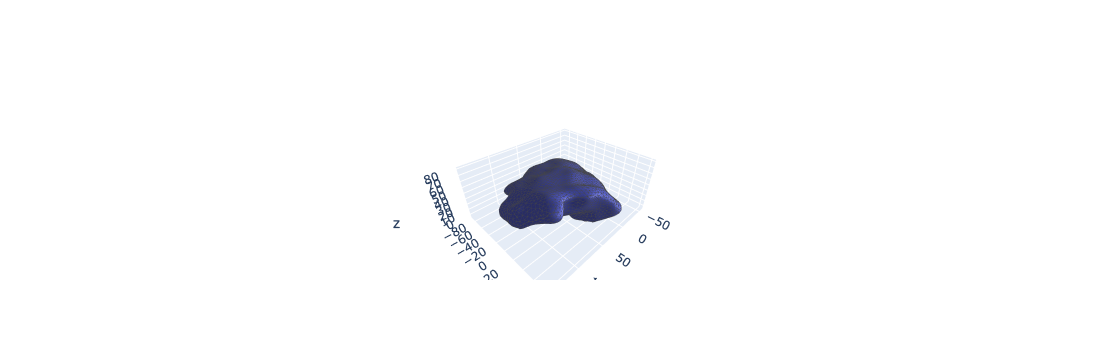

In [19]:
from src.utilities.fin_shape_utils import plot_mesh

bmp_mesh = fin_mesh_list[bmp_indices[0]]
fig, _, _ = plot_mesh(bmp_mesh, surf_alpha=1)

fig.show()

In [31]:
import plotly.express as px 

wt_indices = np.where(wt_filter & stage_filter)[0]

wt_df = fin_df_list[wt_indices[2]]
wt_df["nucleus_id_str"] = wt_df["nucleus_id"].astype(str)

wt_mesh = fin_mesh_list[wt_indices[2]]
v = wt_mesh.vertices.copy()
v = v[:, ::-1]
wt_mesh.vertices = v
fig, _, _ = plot_mesh(wt_mesh, surf_alpha=1)

fig.show()



In [34]:
wt_mesh = fin_mesh_list[wt_indices[2]]
vm = np.min(wt_mesh.vertices[:, 0])


new_mesh = wt_mesh.copy()

v = wt_mesh.vertices.copy()
# v = v[:, ::-1]
v = v*0.5
vmn = np.min(v[:, 2])
v += vm - vmn
new_mesh.vertices = vm
fig, _, _ = plot_mesh(new_mesh, surf_alpha=1)

fig.show()

IndexError: index 260 is out of bounds for axis 0 with size 1

In [28]:
vm.shape

()

In [ ]:
wt_indices = np.where(wt_filter & stage_filter)[0]

wt_mesh = fin_mesh_list[wt_indices[5]]

v = wt_mesh.vertices.copy()
wt_mesh.vertices = v[:, ::-1]

_, lines, surf = plot_mesh(wt_mesh, surf_alpha=1)

fig = go.Figure()

surf.intensity = wt_mesh.vertices[:, 2]
fig.add_traces(surf)

fig.add_traces(lines)

# Turn off axes
fig.update_layout(scene=dict(
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    zaxis=dict(visible=False)
))

fig.show()

In [ ]:
tgfb_indices = np.where(tgfb_filter & stage_filter)[0]

tgfb_mesh = fin_mesh_list[tgfb_indices[2]]
_, lines, surf = plot_mesh(tgfb_mesh, surf_alpha=1)

fig = go.Figure()

fig.add_traces(surf)

fig.add_traces(lines)

fig.show()

In [ ]:
ra_indices = np.where(ra_filter & stage_filter)[0]

ra_mesh = fin_mesh_list[ra_indices[0]]
_, lines, surf = plot_mesh(ra_mesh, surf_alpha=1)

fig = go.Figure()

fig.add_traces(surf)

fig.add_traces(lines)

fig.show()